# Proyek Klasifikasi Gambar: Animal Image Classification Dataset
- **Nama:** Dwi Rizki Kurnia
- **Email:** dwirizkikurnia94@gmail.com
- **ID Dicoding:** MC009D5X2369

https://www.kaggle.com/datasets/borhanitrash/animal-image-classification-dataset

## Import Semua Packages/Library yang Digunakan

In [10]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
from sklearn.metrics import classification_report, confusion_matrix

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
!pip install tensorflowjs
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
import tensorflowjs as tfjs
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Rescaling

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [12]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


#**Data Loading**#

In [14]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"dwirizkii","key":"300e9ddb5b0895ddab3368691253d049"}'}

In [15]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [16]:
!kaggle datasets download -d borhanitrash/animal-image-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/borhanitrash/animal-image-classification-dataset
License(s): MIT
  0% 0.00/38.4M [00:00<?, ?B/s]
100% 38.4M/38.4M [00:00<00:00, 1.08GB/s]


In [17]:
!unzip animal-image-classification-dataset.zip -d animal_dataset

Archive:  animal-image-classification-dataset.zip
  inflating: animal_dataset/Animals/cats/0_0001.jpg  
  inflating: animal_dataset/Animals/cats/0_0002.jpg  
  inflating: animal_dataset/Animals/cats/0_0003.jpg  
  inflating: animal_dataset/Animals/cats/0_0004.jpg  
  inflating: animal_dataset/Animals/cats/0_0005.jpg  
  inflating: animal_dataset/Animals/cats/0_0006.jpg  
  inflating: animal_dataset/Animals/cats/0_0007.jpg  
  inflating: animal_dataset/Animals/cats/0_0008.jpg  
  inflating: animal_dataset/Animals/cats/0_0009.jpg  
  inflating: animal_dataset/Animals/cats/0_0010.jpg  
  inflating: animal_dataset/Animals/cats/0_0011.jpg  
  inflating: animal_dataset/Animals/cats/0_0012.jpg  
  inflating: animal_dataset/Animals/cats/0_0013.jpg  
  inflating: animal_dataset/Animals/cats/0_0014.jpg  
  inflating: animal_dataset/Animals/cats/0_0015.jpg  
  inflating: animal_dataset/Animals/cats/0_0016.jpg  
  inflating: animal_dataset/Animals/cats/0_0017.jpg  
  inflating: animal_dataset/Anim

gabung data

In [18]:
base_dir = "animal_dataset"
source_dir = os.path.join(base_dir, "Animals")
combined_dir = os.path.join(base_dir, "combined")

# Buat folder combined dan subfoldernya jika belum ada
if not os.path.exists(combined_dir):
    os.makedirs(combined_dir)

for category in ["cats", "dogs", "snakes"]:
    combined_category_dir = os.path.join(combined_dir, category)
    if not os.path.exists(combined_category_dir):
        os.makedirs(combined_category_dir)

    src_category_dir = os.path.join(source_dir, category)
    if os.path.exists(src_category_dir):
        for fname in os.listdir(src_category_dir):
            src_path = os.path.join(src_category_dir, fname)
            dst_path = os.path.join(combined_category_dir, fname)
            shutil.copy(src_path, dst_path)

print("Selesai menggabungkan data dari Animals ke combined.")

Selesai menggabungkan data dari Animals ke combined.


#**Plot gambar sampel untuk semua kelas**#

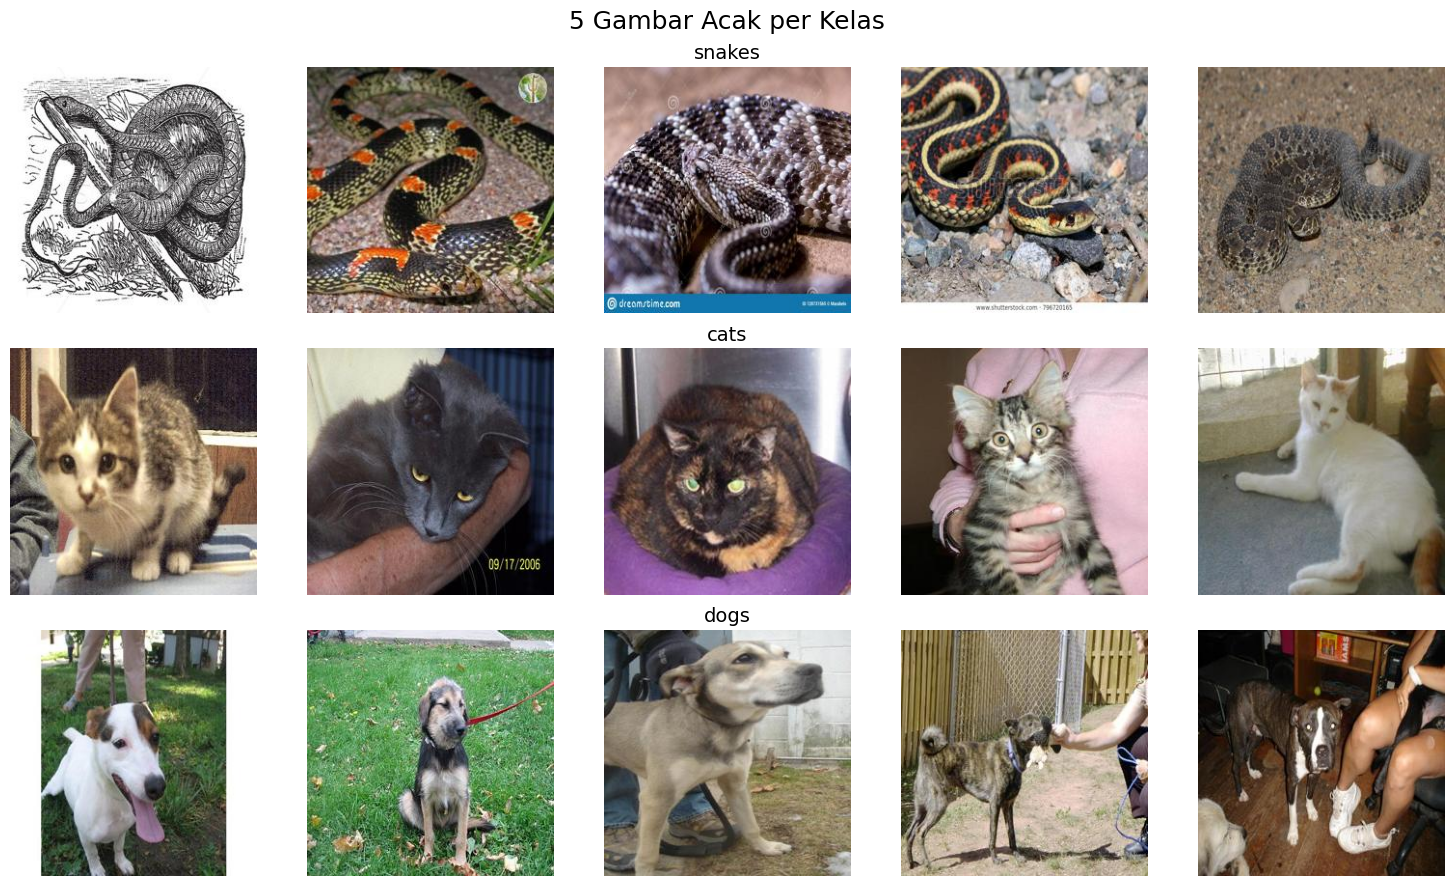

In [19]:
data_dir = 'animal_dataset/Animals'
class_names = os.listdir(data_dir)

plt.figure(figsize=(15, 9))

num_samples = 5

for i, class_name in enumerate(class_names):
    class_path = os.path.join(data_dir, class_name)
    images = os.listdir(class_path)
    sample_images = random.sample(images, num_samples)  # ambil 5 gambar acak

    for j, img_name in enumerate(sample_images):
        img_path = os.path.join(class_path, img_name)
        img = mpimg.imread(img_path)

        plt.subplot(len(class_names), num_samples, i * num_samples + j + 1)
        plt.imshow(img)
        if j == 2:
            plt.title(class_name, fontsize=14)
        plt.axis('off')

plt.suptitle("5 Gambar Acak per Kelas", fontsize=18)
plt.tight_layout()
plt.show()

#**Plot distribusi gambar di seluruh kelas**#

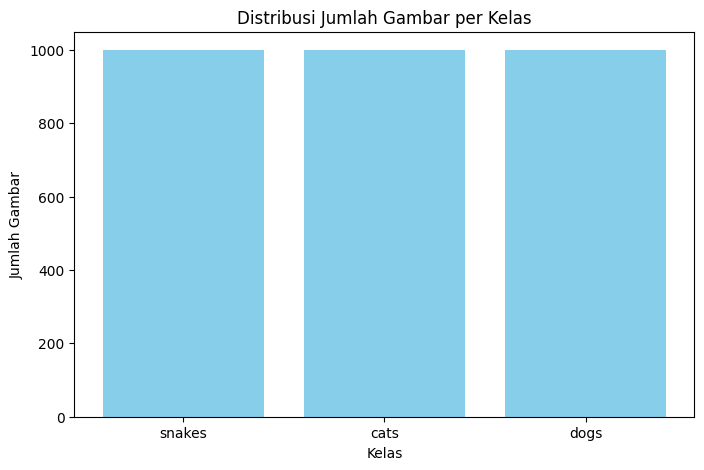

In [20]:
data_dir = 'animal_dataset/Animals'
class_names = os.listdir(data_dir)

# Hitung jumlah gambar per kelas
class_counts = []
for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    count = len(os.listdir(class_path))
    class_counts.append(count)

# Plot distribusi
plt.figure(figsize=(8,5))
plt.bar(class_names, class_counts, color='skyblue')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.title('Distribusi Jumlah Gambar per Kelas')
plt.show()

# **Data Splitting : Training and Testing**

In [21]:
# 1. Lokasi dataset asli
mypath = 'animal_dataset/combined'

# 2. Siapkan list untuk path, nama file, dan label
file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(mypath):
    for name in files:
        if name.endswith(('.jpg', '.jpeg', '.png')):
            full_path.append(os.path.join(path, name))
            labels.append(path.split('/')[-1])
            file_name.append(name)

In [22]:
# 3. Simpan ke DataFrame agar rapi
df = pd.DataFrame({"path": full_path, "file_name": file_name, "labels": labels})
print(df.groupby(['labels']).size())  # Cek distribusi label

labels
cats      1000
dogs      1000
snakes    1000
dtype: int64


In [23]:
# 4. Siapkan variabel X dan y
X = df['path']
y = df['labels']

In [24]:
# 5. Split menjadi train dan sisa
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=300)

In [25]:
# 6. Split sisa menjadi val dan test (50:50 dari 30% → 15% val, 15% test)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=300)

In [26]:
# 7. Buat dataframe masing-masing set
df_train = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_val = pd.DataFrame({'path': X_val, 'labels': y_val, 'set': 'val'})
df_test = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})

In [27]:
# 8. Gabungkan semua
df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)

In [28]:
# 9. Cek distribusi
print('\nDistribusi data per set dan label:')
print(df_all.groupby(['set', 'labels']).size())


Distribusi data per set dan label:
set    labels
test   cats      150
       dogs      150
       snakes    150
train  cats      700
       dogs      700
       snakes    700
val    cats      150
       dogs      150
       snakes    150
dtype: int64


In [29]:
# 10. Siapkan folder tujuan
dataset_path = 'animal_dataset/split_final'

In [30]:
# 11. Salin file ke folder baru sesuai set dan label
for index, row in tq(df_all.iterrows(), total=len(df_all)):
    src_path = row['path']
    label = row['labels']
    subset = row['set']

    dest_dir = os.path.join(dataset_path, subset, label)
    os.makedirs(dest_dir, exist_ok=True)

    dest_file = os.path.join(dest_dir, os.path.basename(src_path))
    if not os.path.exists(dest_file):
        shutil.copy2(src_path, dest_file)

print("\n✅ Semua gambar telah dipisahkan ke folder train, val, dan test.")

  0%|          | 0/3000 [00:00<?, ?it/s]


✅ Semua gambar telah dipisahkan ke folder train, val, dan test.


# **Image Data Generator**

In [31]:
# Definisikan direktori training, validation, dan testing
TRAIN_DIR = "animal_dataset/split_final/train"
VAL_DIR = "animal_dataset/split_final/val"
TEST_DIR = "animal_dataset/split_final/test"

# Cek jumlah gambar per label di masing-masing folder
for label in ['cats', 'dogs', 'snakes']:
    print(f"Jumlah gambar di train/{label}:", len(os.listdir(os.path.join(TRAIN_DIR, label))))
    print(f"Jumlah gambar di val/{label}:", len(os.listdir(os.path.join(VAL_DIR, label))))
    print(f"Jumlah gambar di test/{label}:", len(os.listdir(os.path.join(TEST_DIR, label))))
    print("-" * 40)

Jumlah gambar di train/cats: 700
Jumlah gambar di val/cats: 150
Jumlah gambar di test/cats: 150
----------------------------------------
Jumlah gambar di train/dogs: 700
Jumlah gambar di val/dogs: 150
Jumlah gambar di test/dogs: 150
----------------------------------------
Jumlah gambar di train/snakes: 700
Jumlah gambar di val/snakes: 150
Jumlah gambar di test/snakes: 150
----------------------------------------


In [32]:
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'animal_dataset/split_final/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    'animal_dataset/split_final/val',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    'animal_dataset/split_final/test',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 2100 images belonging to 3 classes.
Found 450 images belonging to 3 classes.
Found 450 images belonging to 3 classes.


## Modelling

**Latih Model dengan Model MobileNetV2**

In [33]:
# Load pretrained model tanpa top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

model = Sequential([
    base_model,
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 64)       │       737,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,086,083 (11.77 MB)

 Trainable params: 828,099 (3.16 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [34]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(patience=3)
    ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.7417 - loss: 0.9808 - val_accuracy: 0.9578 - val_loss: 0.1197 - learning_rate: 0.0010
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.9695 - loss: 0.0842 - val_accuracy: 0.9733 - val_loss: 0.0964 - learning_rate: 0.0010
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.9710 - loss: 0.0824 - val_accuracy: 0.9667 - val_loss: 0.0752 - learning_rate: 0.0010
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.9711 - loss: 0.0819 - val_accuracy: 0.9400 - val_loss: 0.1991 - learning_rate: 0.0010
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.9702 - loss: 0.0872 - val_accuracy: 0.9711 - val_loss: 0.0807 - learning_rate: 0.0010
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.9773 - loss: 0.0752 - val_accuracy: 0.9556 - val_loss: 0.1527 - learning_rate: 0.0010
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.9827 - loss: 0.0623 - val_acc

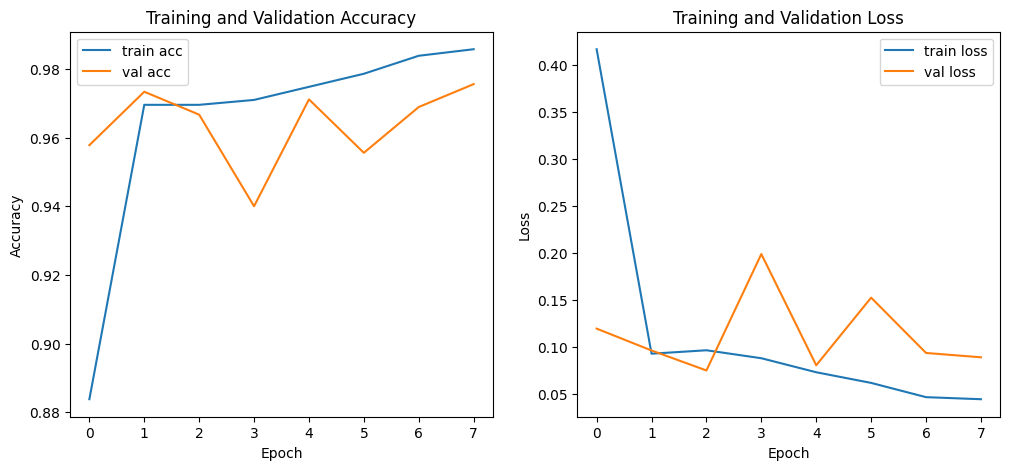

In [35]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9819 - loss: 0.0416
Test accuracy: 98.67%
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step
              precision    recall  f1-score   support

        cats       0.97      0.99      0.98       150
        dogs       0.99      0.99      0.99       150
      snakes       1.00      0.99      0.99       150

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450



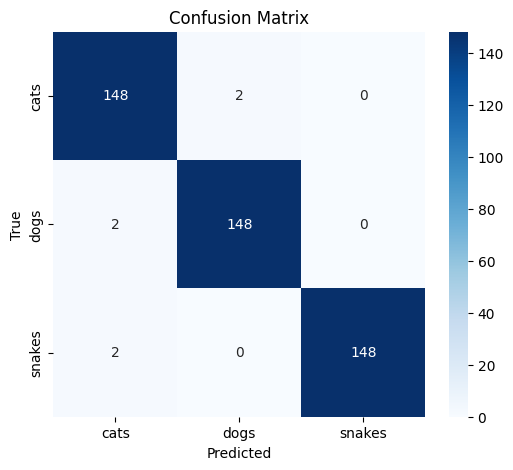

In [36]:
# Evaluasi dengan data test
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc*100:.2f}%")

# Prediksi kelas test
test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = y_pred.argmax(axis=1)

# True label test
y_true = test_generator.classes

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Konversi Model

In [37]:
# ====== Buat folder ======
os.makedirs('submission/saved_model', exist_ok=True)
os.makedirs('submission/tflite', exist_ok=True)
os.makedirs('submission/tfjs_model', exist_ok=True)

# ======================
# 1. SavedModel format
# ======================
model.export('submission/saved_model')

# ======================
# 2. TFLite format
# ======================
# Convert
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model .tflite
with open('submission/tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

# Simpan label
labels = ['cats', 'dogs', 'snakes']
with open('submission/tflite/label.txt', 'w') as f:
    for label in labels:
        f.write(label + '\n')

# ======================
# 3. TFJS format
# ======================
# Simpan ke h5 dulu
model.save('model.h5')
# Convert ke TFJS
tfjs.converters.save_keras_model(model, 'submission/tfjs_model')

Saved artifact at 'submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  133315007228304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133315007226384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133315007228688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133315007228880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133315007225040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133315007224848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133315007226576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133315007225808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133315007225232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133315007227920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1333

failed to lookup keras version from the file,
    this is likely a weight only file


## Inference (Optional)

In [38]:
# Load kembali model yang sudah disimpan
loaded_model = tf.keras.models.load_model('model.h5')

# Label urutan kelas (harus sesuai urutan saat training generator)
class_labels = ['cats', 'dogs', 'snakes']

# Path ke gambar uji kucing
test_image_path = 'animal_dataset/split_final/test/cats/0_0142.jpg'


# Preprocessing gambar agar sesuai dengan input model
img = image.load_img(test_image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalisasi

# Prediksi
pred = loaded_model.predict(img_array)
predicted_class = np.argmax(pred, axis=1)

# Tampilkan hasil prediksi
print("Gambar:", test_image_path)
print("Prediksi:", class_labels[predicted_class[0]])
img = image.load_img(test_image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalisasi

# Prediksi
pred = loaded_model.predict(img_array)
predicted_class = np.argmax(pred, axis=1)

# Tampilkan hasil prediksi
print("Gambar:", test_image_path)
print("Prediksi:", class_labels[predicted_class[0]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Gambar: animal_dataset/split_final/test/cats/0_0142.jpg
Prediksi: cats
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Gambar: animal_dataset/split_final/test/cats/0_0142.jpg
Prediksi: cats


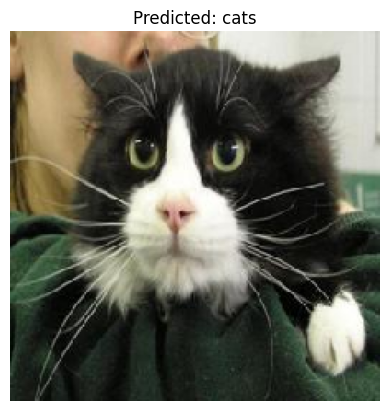

In [39]:
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {class_labels[predicted_class[0]]}")
plt.show()